In [2]:
# Import 
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
edges_df = pd.read_csv('data/api_data/station_distances.csv')
edges_df['Speed'] = 60 * (edges_df['DistanceMiles'] / edges_df['DistanceMinutes'])
edges_df.head()

,FromStationCode,ToStationCode,DistanceMiles,DistanceMinutes,Speed
0,A01,A02,0.75,2.0,22.500000
1,A01,A03,1.23,4.0,18.450000
2,A01,A04,2.40,6.0,24.000000
3,A01,A05,3.10,9.0,20.666667
4,A01,A06,3.73,11.0,20.345455


In [4]:
print(len(edges_df))

10468


In [5]:
# Grab node location data'
station_list_path = 'data/api_data/station_list.xml'
node_locations = pd.read_xml(station_list_path, xpath='./wm:Stations/wm:Station', namespaces={'wm': 'http://www.wmata.com'})
node_locations = node_locations[['Code', 'Lat', 'Lon']]
node_locations.head()
scale = 2
pos = {code: (long*scale, lat*scale) for code, long, lat in zip(node_locations['Code'], node_locations['Lon'], node_locations['Lat'])}

In [6]:
station_list_path = 'data/api_data/station_list.xml'
station_info = pd.read_xml(station_list_path, xpath='./wm:Stations/wm:Station', namespaces={'wm': 'http://www.wmata.com'})
station_info['LineComb'] = station_info['LineCode1'] + station_info['LineCode2'].fillna('') + station_info['LineCode3'].fillna('') + station_info['LineCode4'].fillna('')

print(station_info.head())

              Address Code        Lat LineCode1 LineCode2 LineCode3  \
0  \n                  A01  38.898303        RD      None      None   
1  \n                  A02  38.903192        RD      None      None   
2  \n                  A03  38.909499        RD      None      None   
3  \n                  A04  38.924999        RD      None      None   
4  \n                  A05  38.934703        RD      None      None   

   LineCode4        Lon                           Name StationTogether1  \
0        NaN -77.028099                   Metro Center              C01   
1        NaN -77.039766                 Farragut North             None   
2        NaN -77.043620                  Dupont Circle             None   
3        NaN -77.052648  Woodley Park-Zoo/Adams Morgan             None   
4        NaN -77.058226                 Cleveland Park             None   

   StationTogether2 LineComb  
0               NaN       RD  
1               NaN       RD  
2               NaN       RD 

In [7]:
colors = ['r', 'g', 'b', 'silver', 'orange', 'yellow']
def get_edge_color(row):
    if row['LineComb'] == 'RD':
        return 'red'
    elif row['LineComb'] == 'BL':
        return 'blue'
    elif row['LineComb'] == 'YL':
        return 'yellow'
    elif row['LineComb'] == 'OR':
        return 'orange'
    elif row['LineComb'] == 'GR':
        return 'green'
    elif row['LineComb'] == 'SV':
        return 'silver'
    elif row['LineComb'] == 'BLORSV':
        return 'darkkhaki'
    elif row['LineComb'] == 'BLYL':
        return 'darkgreen'
    elif row['LineComb'] == 'GRYL':
        return 'lime'
    elif row['LineComb'] == 'BLSV':
        return 'lightskyblue'
    elif row['LineComb'] == 'ORSV':
        return 'salmon'
    else:
        return 'black'  # default color (black) for undefined combinations

station_info['LineColor'] = station_info.apply(get_edge_color, axis=1)
node_colormap = station_info['LineColor'].to_list()
station_info.head()

,Address,Code,Lat,LineCode1,LineCode2,LineCode3,LineCode4,Lon,Name,StationTogether1,StationTogether2,LineComb,LineColor
0,\n,A01,38.898303,RD,None,None,NaN,-77.028099,Metro Center,C01,NaN,RD,red
1,\n,A02,38.903192,RD,None,None,NaN,-77.039766,Farragut North,None,NaN,RD,red
2,\n,A03,38.909499,RD,None,None,NaN,-77.043620,Dupont Circle,None,NaN,RD,red
3,\n,A04,38.924999,RD,None,None,NaN,-77.052648,Woodley Park-Zoo/Adams Morgan,None,NaN,RD,red
4,\n,A05,38.934703,RD,None,None,NaN,-77.058226,Cleveland Park,None,NaN,RD,red


In [8]:
# Create custom legend
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='silver', lw=4),
                Line2D([0], [0], color='darkkhaki', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='lime', lw=4),
                Line2D([0], [0], color='lightskyblue', lw=4),
                Line2D([0], [0], color='salmon', lw=4),
                Line2D([0], [0], color='black', lw=4)]
legend_labels = ['Red Line', 'Blue Line', 'Yellow Line', 'Orange Line', 'Green Line', 'Silver Line',
                 'Blue-Orange-Silver', 'Blue-Yellow', 'Green-Yellow', 'Blue-Silver', 'Orange-Silver', 'Other']

In [9]:
# Create network graph from Edges in Minutes
G = nx.from_pandas_edgelist(edges_df, source='FromStationCode', target='ToStationCode', edge_attr='Speed')


In [14]:
# Grab ten fastest segments
fastest_df = edges_df[edges_df['FromStationCode'] < edges_df['ToStationCode']].nlargest(10, 'Speed')
fastests = [(row.FromStationCode, row.ToStationCode) for _, row in fastest_df.iterrows()]
print(f"Got {len(fastests)} fastest segments")
fastest_edges = [(u, v, d) for u, v, d in G.edges(data=True) if (u, v) in fastests or (v, u) in fastests]
print(fastest_edges)


Got 10 fastest segments
[('A10', 'A11', {'Speed': 44.599999999999994}), ('C11', 'C12', {'Speed': 42.0}), ('C13', 'J02', {'Speed': 45.36}), ('D07', 'G01', {'Speed': 44.1}), ('D08', 'G01', {'Speed': 46.4}), ('E08', 'E10', {'Speed': 42.1}), ('E09', 'E10', {'Speed': 49.00000000000001}), ('F09', 'F10', {'Speed': 42.0}), ('K07', 'K08', {'Speed': 49.6}), ('N04', 'N06', {'Speed': 42.375})]


In [13]:
# Grab ten slowest segments, filtered to avoid duplicates
slowest_df = edges_df[edges_df['FromStationCode'] < edges_df['ToStationCode']].nsmallest(10, 'Speed')
slowests = [(row.FromStationCode, row.ToStationCode) for _, row in slowest_df.iterrows()]
print(f"Got {len(slowests)} slowest segments")
slowest_edges = [(u, v, d) for u, v, d in G.edges(data=True) if (u, v) in slowests or (v, u) in slowests]
print(slowest_edges)


Got 10 slowest segments
[('A01', 'F02', {'Speed': 4.2}), ('B01', 'D01', {'Speed': 3.75}), ('B02', 'F02', {'Speed': 4.050000000000001}), ('C01', 'F02', {'Speed': 4.2}), ('C02', 'E01', {'Speed': 4.04}), ('C02', 'F02', {'Speed': 4.476923076923077}), ('D01', 'E01', {'Speed': 4.457142857142857}), ('D01', 'F01', {'Speed': 3.75}), ('D01', 'F02', {'Speed': 3.4909090909090907})]


In [19]:
# Get Station->Station name info for text print
station_name_map = {row['Code']: row['Name'] for _, row in station_info.iterrows()}
fastest_df['FromName'] = fastest_df['FromStationCode'].map(station_name_map)
fastest_df['ToName'] = fastest_df['ToStationCode'].map(station_name_map)
fastest_edges_str = "\n".join([f"{row.FromName}({row.FromStationCode}) to {row.ToName}({row.ToStationCode}): {row.Speed:.2f} MPH" for _, row in fastest_df.iterrows()])
print(fastest_edges_str)
print("----")
slowest_df['FromName'] = slowest_df['FromStationCode'].map(station_name_map)
slowest_df['ToName'] = slowest_df['ToStationCode'].map(station_name_map)
slowest_edges_str = "\n".join([f"{row.FromName}({row.FromStationCode}) to {row.ToName}({row.ToStationCode}): {row.Speed:.2f} MPH" for _, row in slowest_df.iterrows()])
print(slowest_edges_str)

Dunn Loring-Merrifield(K07) to Vienna/Fairfax-GMU(K08): 49.60 MPH
College Park-U of Md(E09) to Greenbelt(E10): 49.00 MPH
Stadium-Armory(D08) to Benning Road(G01): 46.40 MPH
King St-Old Town(C13) to Van Dorn Street(J02): 45.36 MPH
Medical Center(A10) to Grosvenor-Strathmore(A11): 44.60 MPH
Potomac Ave(D07) to Benning Road(G01): 44.10 MPH
Spring Hill(N04) to Wiehle-Reston East(N06): 42.38 MPH
Hyattsville Crossing(E08) to Greenbelt(E10): 42.10 MPH
Potomac Yard(C11) to Braddock Road(C12): 42.00 MPH
Naylor Road(F09) to Suitland(F10): 42.00 MPH
----
Federal Triangle(D01) to Archives-Navy Memorial-Penn Quarter(F02): 3.49 MPH
Gallery Pl-Chinatown(B01) to Federal Triangle(D01): 3.75 MPH
Federal Triangle(D01) to Gallery Pl-Chinatown(F01): 3.75 MPH
McPherson Square(C02) to Mt Vernon Sq 7th St-Convention Center(E01): 4.04 MPH
McPherson Square(C02) to Mt Vernon Sq 7th St-Convention Center(E01): 4.04 MPH
Judiciary Square(B02) to Archives-Navy Memorial-Penn Quarter(F02): 4.05 MPH
Metro Center(A01) to

In [64]:
# Get fastest nodes to make bigger visually
fastest_nodes = fastest_df['FromStationCode'].tolist() + fastest_df['ToStationCode'].tolist()
f_node_sizes = []
for node in G.nodes():
    if node in fastest_nodes:
        f_node_sizes.append(500)
    else:
        f_node_sizes.append(50)   

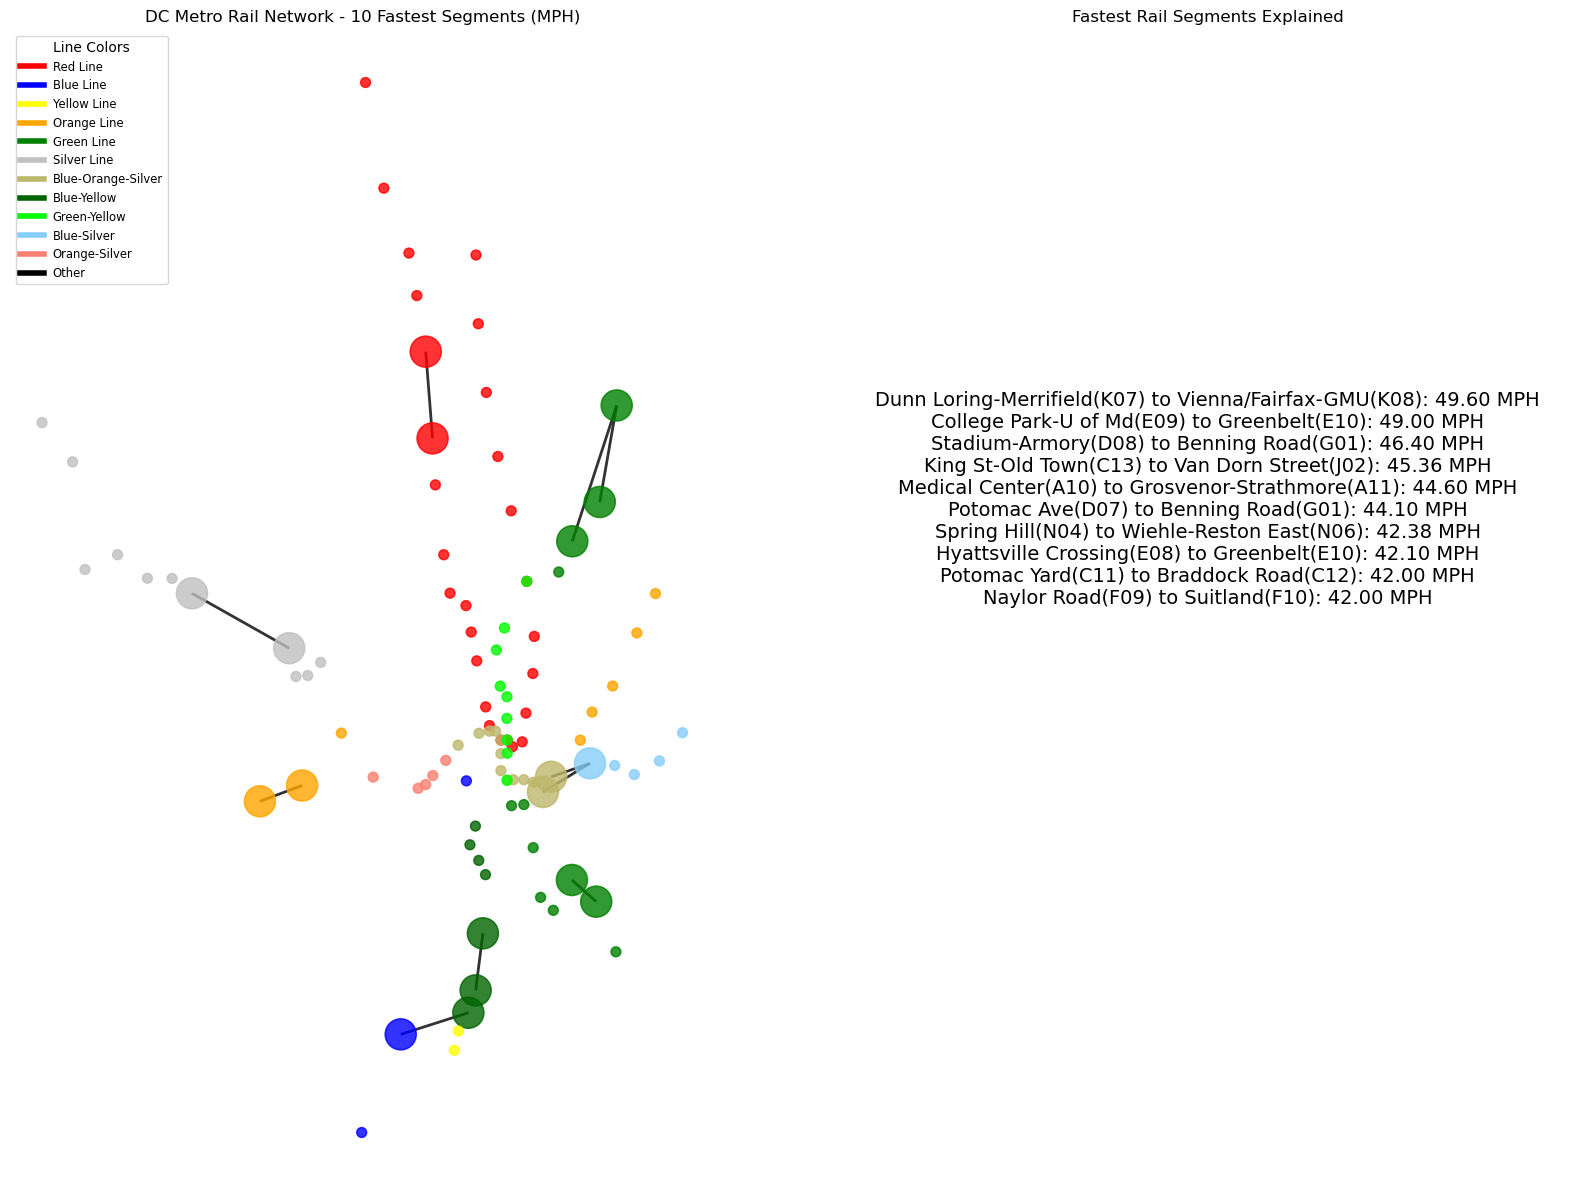

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
nx.draw(G, 
        ax=ax1,
        pos=pos, 
        node_color=node_colormap, 
        edgelist=fastest_edges, 
        node_size=f_node_sizes,
        width=2,
        linewidths=1.1,
        font_size=8,
        alpha=0.8
        )
ax2.text(0.5, 0.5, fastest_edges_str, fontsize=14, va='bottom', ha='center')
ax2.axis('off')
ax1.set_title('DC Metro Rail Network - 10 Fastest Segments (MPH)')
ax1.legend(custom_lines, legend_labels, loc='upper left', fontsize='small', title='Line Colors')
ax2.set_title('Fastest Rail Segments Explained')
plt.savefig('dc_metro_fastest_segments.png', dpi=300)
plt.show()

In [ ]:
# Get smallest nodes to make bigger visually
slowest_nodes = slowest_df['FromStationCode'].tolist() + slowest_df['ToStationCode'].tolist()
node_sizes = []
for node in G.nodes():
    if node in slowest_nodes:
        node_sizes.append(500)
    else:
        node_sizes.append(50)   

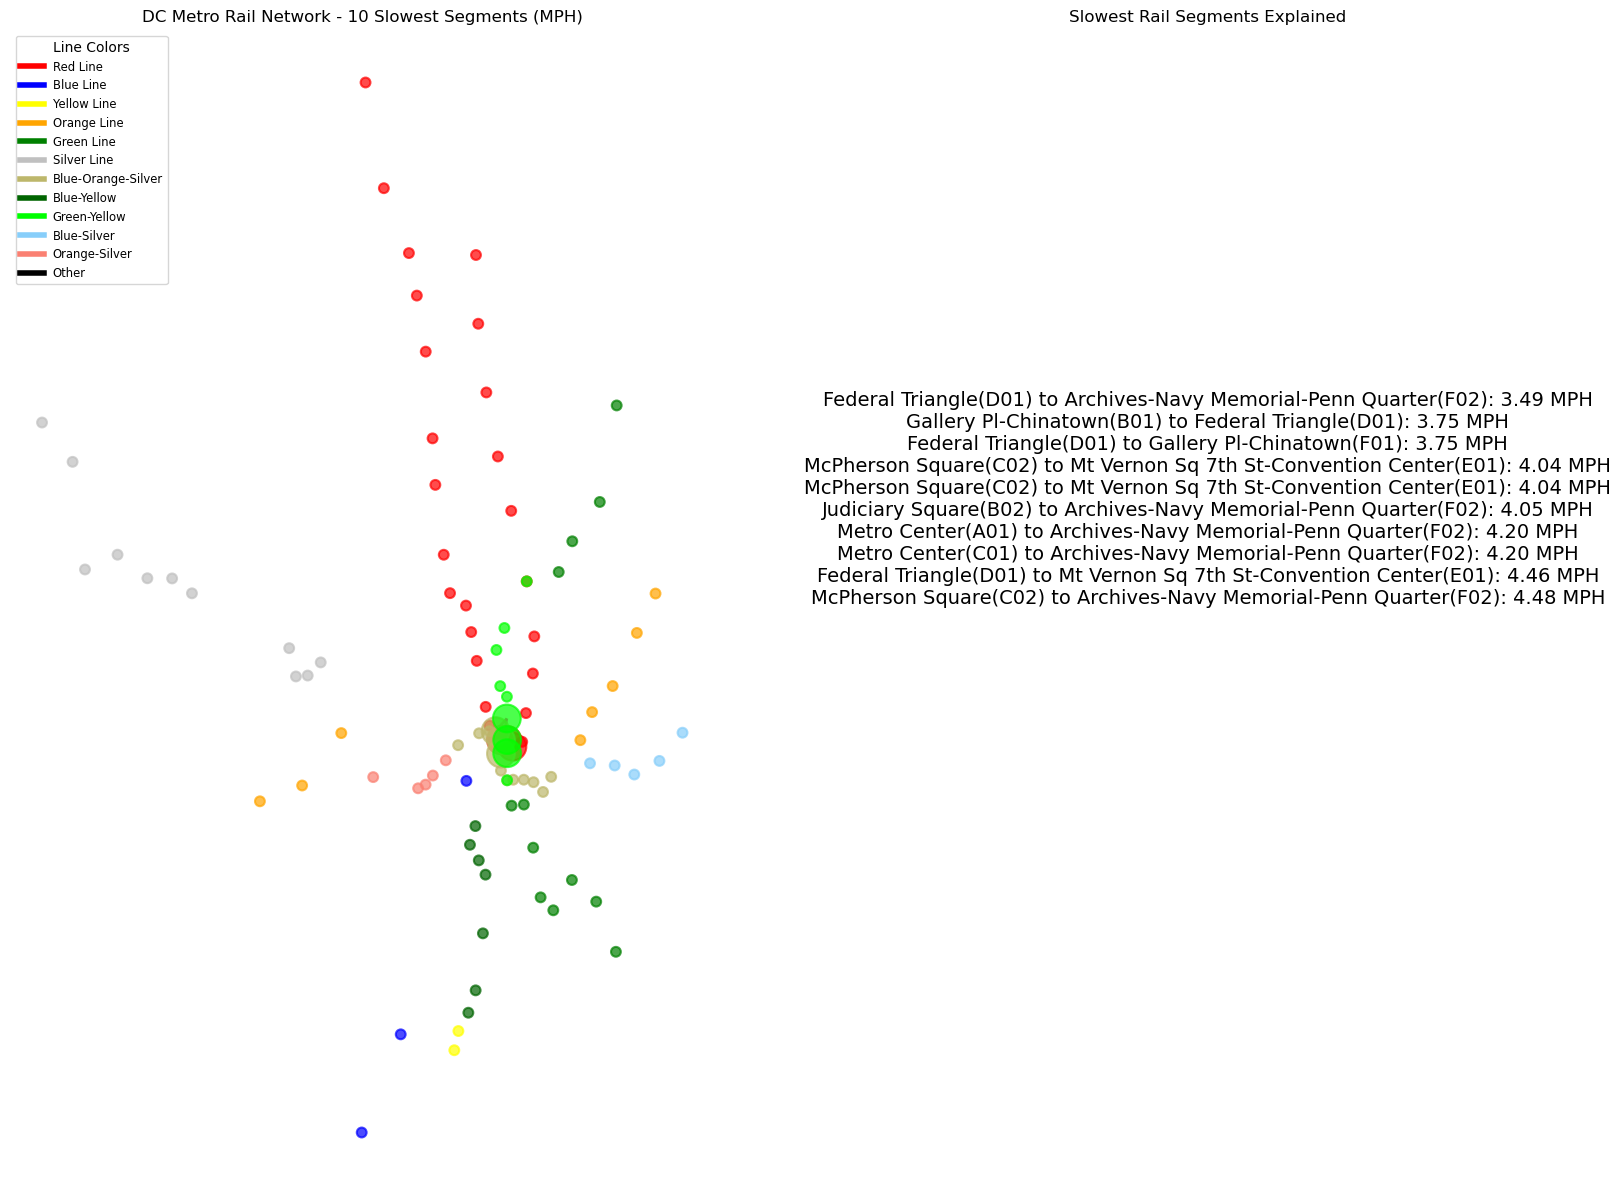

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
nx.draw(G, 
        ax=ax1,
        pos=pos, 
        node_color=node_colormap, 
        edge_color='deeppink',
        edgelist=slowest_edges, 
        node_size=node_sizes,
        width=2,
        linewidths=1.5,
        font_size=8,
        alpha=0.7
        )
ax2.text(0.5, 0.5, slowest_edges_str, fontsize=14, va='bottom', ha='center')
ax2.axis('off')
ax1.set_title('DC Metro Rail Network - 10 Slowest Segments (MPH)')
ax1.legend(custom_lines, legend_labels, loc='upper left', fontsize='small', title='Line Colors')
ax2.set_title('Slowest Rail Segments Explained')
plt.savefig('dc_metro_slowest_segments.png', dpi=300)
plt.show()